try out  learning rate scheduling

### Ingest and Explore

In [1]:
import numpy as np
from pathlib import Path
from time import strftime
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

2024-05-05 13:32:57.209335: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-05 13:32:59.048897: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-05 13:33:04.281191: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 13:33:13.252678: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

In [4]:
X_train_full.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    shuffle=True,
    test_size=10_000, 
    stratify=y_train_full,
    random_state=42
)

In [6]:
X_train.shape, X_val.shape, X_test.shape

((50000, 28, 28), (10000, 28, 28), (10000, 28, 28))

In [7]:
y_train.shape, y_val.shape, y_test.shape

((50000,), (10000,), (10000,))

In [8]:
def get_value_counts(target, name):
    value_counts = pd.Series(target, name=name).value_counts()
    percentages = (value_counts/len(target)) * 100

    vcs = pd.DataFrame({
        f"{name} counts": value_counts,
        f"{name} %": percentages
    })
    return vcs

In [9]:
ytr = get_value_counts(y_train, name="y_train")
yva = get_value_counts(y_val, name="y_val")
yte = get_value_counts(y_test, name='y_test')
# yte

In [10]:
pd.concat([ytr, yva, yte], axis=1, keys=['train', 'validation', 'test']).sort_index()

train             validation                  test         
  y_train counts y_train % y_val counts y_val % y_test counts y_test %
0           5000      10.0         1000    10.0          1000     10.0
1           5000      10.0         1000    10.0          1000     10.0
2           5000      10.0         1000    10.0          1000     10.0
3           5000      10.0         1000    10.0          1000     10.0
4           5000      10.0         1000    10.0          1000     10.0
5           5000      10.0         1000    10.0          1000     10.0
6           5000      10.0         1000    10.0          1000     10.0
7           5000      10.0         1000    10.0          1000     10.0
8           5000      10.0         1000    10.0          1000     10.0
9           5000      10.0         1000    10.0          1000     10.0

In [11]:
ps = pd.concat(
    [ytr.loc[:, "y_train %"], yva.loc[:, "y_val %"], yte.loc[:, "y_test %"]],
    axis=1).sort_index()
ps["labels"] = ps.index

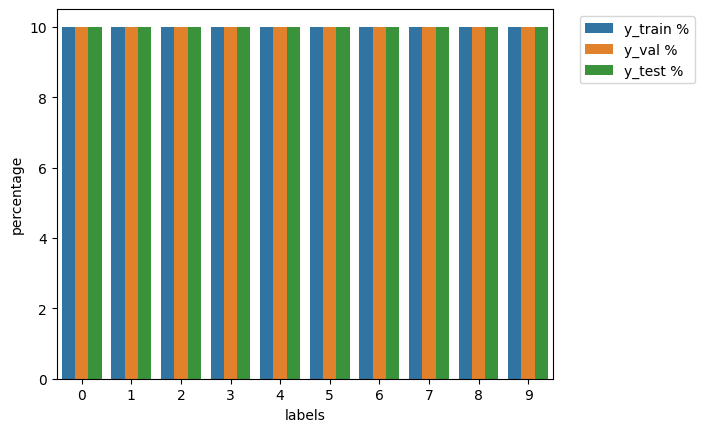

In [12]:
melted = ps.melt(id_vars='labels', var_name='value', value_name='percentage')
# melted
sns.barplot(data=melted, x='labels', y='percentage', hue='value')
plt.legend(bbox_to_anchor = (1.3, 1), loc='upper right')

The dataset is properly stratified

In [13]:
y_train

array([9, 9, 0, ..., 4, 7, 1], dtype=uint8)

In [14]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [15]:
class_names[y_train[0]]

'Ankle boot'

In [16]:
X_train[0].min(), X_train[0].max()

(0, 255)

In [17]:
X_train.min(), X_train.max()

(0, 255)

In [18]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

In [19]:
X_train.min(), X_train.max()

(0.0, 1.0)

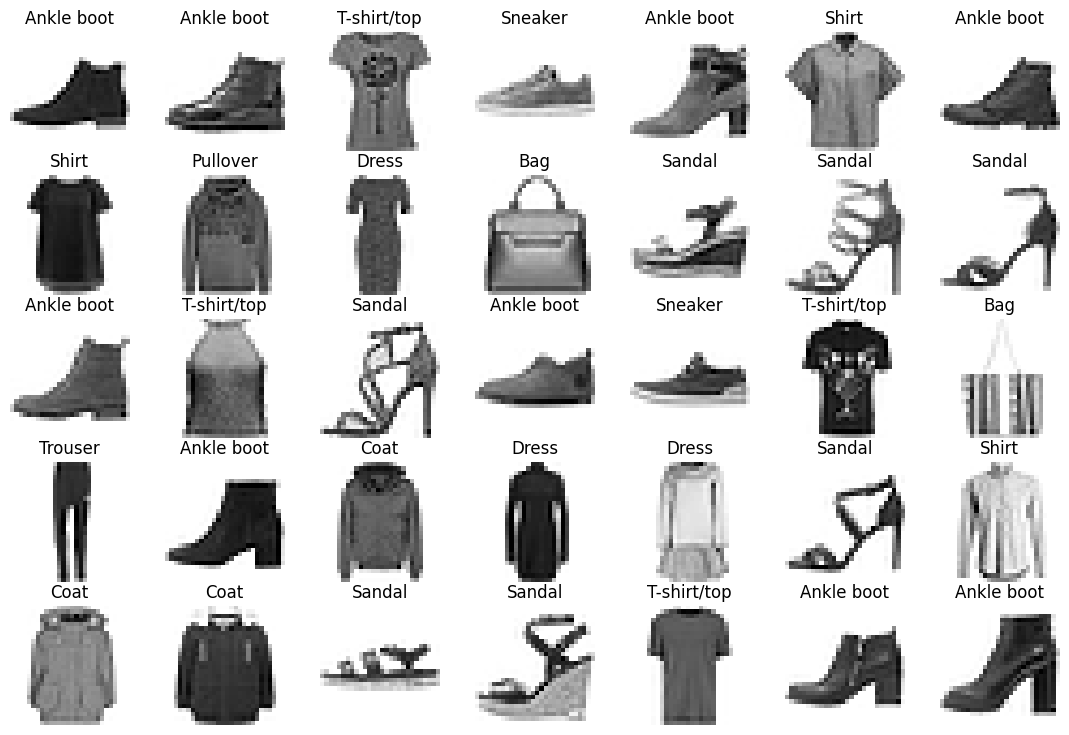

In [20]:
#  Plot a few more images from the dataset
plt.figure(figsize=(14, 9))
for idx, image_data in enumerate(X_train[:35]):
    plt.subplot(5, 7, idx + 1)
    plt.imshow(image_data, cmap="binary")
    plt.axis('off')
    plt.title(class_names[y_train[idx]])
plt.subplots_adjust(wspace=0, hspace=0.2)
plt.show();

### Tune hyperparameters

In [21]:
input_shape = X_train[0].shape
input_shape

(28, 28)

In [22]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=2, max_value=5)
    
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    
    initializer = hp.Choice("kernel_initializer", values=["he_normal", "he_uniform"])
    if initializer == 'he_normal':
        initializer = tf.keras.initializers.he_normal()
    elif initializer == 'he_normal':
        initializer = tf.keras.initializers.he_uniform()

    activation = hp.Choice('activation', values=['relu', 'leaky_relu', 'swish'])
    if activation == 'relu':
        activation = tf.keras.activations.relu
    elif activation == 'leaky_relu':
        activation = tf.keras.activations.leaky_relu
    elif activation == 'swish':
        activation = tf.keras.activations.swish
    
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=input_shape))
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(
            200, #200 neurons fixed
            activation=activation,
            kernel_initializer=initializer
        ))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [23]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=20, overwrite=False,
    directory="my_fashion_mnist", project_name="random_search", seed=42)

In [24]:
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_val, y_val))

Trial 20 Complete [00h 01m 24s]
val_accuracy: 0.8930000066757202

Best val_accuracy So Far: 0.8964999914169312
Total elapsed time: 00h 22m 58s


In [25]:
best_trials = random_search_tuner.oracle.get_best_trials(num_trials=5)

In [26]:
best_trials[0].summary()

Trial 18 summary
Hyperparameters:
n_hidden: 3
learning_rate: 0.0009719978423652108
kernel_initializer: he_normal
activation: swish
optimizer: adam
Score: 0.8964999914169312


In [27]:
best_trials[1].summary()

Trial 11 summary
Hyperparameters:
n_hidden: 2
learning_rate: 0.0005161743428272905
kernel_initializer: he_normal
activation: relu
optimizer: adam
Score: 0.896399974822998


In [28]:
best_trials[2].summary()

Trial 08 summary
Hyperparameters:
n_hidden: 2
learning_rate: 0.0009824542588158123
kernel_initializer: he_uniform
activation: relu
optimizer: adam
Score: 0.8952000141143799


### Train deep Sequential model

In [29]:
input_shape = X_train[0].shape
input_shape

(28, 28)

In [30]:
tf.keras.backend.clear_session()
activation_f = tf.keras.activations.swish
initializer_f = tf.keras.initializers.he_normal()

tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(shape=input_shape))
model.add(tf.keras.layers.Flatten())
for _ in range(4): # 4 hidden layers
    model.add(tf.keras.layers.Dense(
        200,
        activation=activation_f,
        kernel_initializer=initializer_f
    ))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │       157,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         2,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 279,610 (1.07 MB)

 Trainable params: 279,610 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

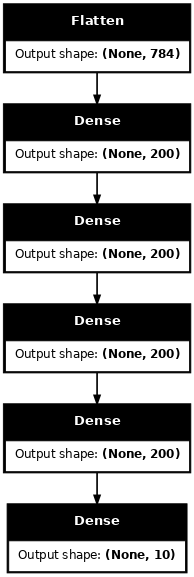

In [32]:
tf.keras.utils.plot_model(model, to_file="model_plots/sequential_fashion_mnist.png", show_shapes=True, dpi=60)

In [33]:
y_train[:5]

array([9, 9, 0, 7, 9], dtype=uint8)

In [34]:
optimizer_f = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss_f = tf.keras.losses.sparse_categorical_crossentropy
metrics_f = tf.keras.metrics.sparse_categorical_accuracy

model.compile(
    loss=loss_f,
    optimizer=optimizer_f,
    metrics=[metrics_f]
)

In [35]:
len(X_train) / 32 
## 55,000 values in per epoch / 32 batches

1562.5

In [36]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience = 10,
    restore_best_weights=True
)

In [37]:
# save checkpoints
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "trained_weights/mnist_sequential.weights.h5",
    save_best_only=True,
    save_weights_only=True)

In [38]:
# setup tensorboard
def get_run_logdir(root_logdir="training_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

In [39]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    run_logdir
)

In [40]:
history = model.fit(
    X_train, y_train, epochs=60, batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, checkpoint_callback, tensorboard_callback]
    )

Epoch 1/60
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.8664 - sparse_categorical_accuracy: 0.7095 - val_loss: 0.4370 - val_sparse_categorical_accuracy: 0.8455
Epoch 2/60
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.4301 - sparse_categorical_accuracy: 0.8456 - val_loss: 0.3805 - val_sparse_categorical_accuracy: 0.8656
Epoch 3/60
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.3815 - sparse_categorical_accuracy: 0.8622 - val_loss: 0.3560 - val_sparse_categorical_accuracy: 0.8712
Epoch 4/60
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.3532 - sparse_categorical_accuracy: 0.8700 - val_loss: 0.3425 - val_sparse_categorical_accuracy: 0.8761
Epoch 5/60
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.3326 - sparse_categorical_accuracy: 0.8777 - val_loss: 0.3337 - val_sparse_categorical_accuracy: 0.8782
Epoch 6/60
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.3163 - sparse_categorical_accuracy: 0.8832 - val_loss: 0.3273 - val_sparse_categorical_acc

In [42]:
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard --logdir training_logs

In [41]:
h = pd.DataFrame(history.history)
h

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
0,0.608162,0.79042,0.437012,0.8455
1,0.419259,0.84888,0.380505,0.8656
2,0.377891,0.86272,0.356000,0.8712
3,0.351984,0.87052,0.342516,0.8761
4,0.332627,0.87776,0.333678,0.8782
5,0.316977,0.88298,0.327345,0.8809
6,0.303617,0.88776,0.322547,0.8820
7,0.291796,0.89192,0.318927,0.8837
8,0.281084,0.89592,0.316139,0.8840
9,0.271197,0.89928,0.313860,0.8844


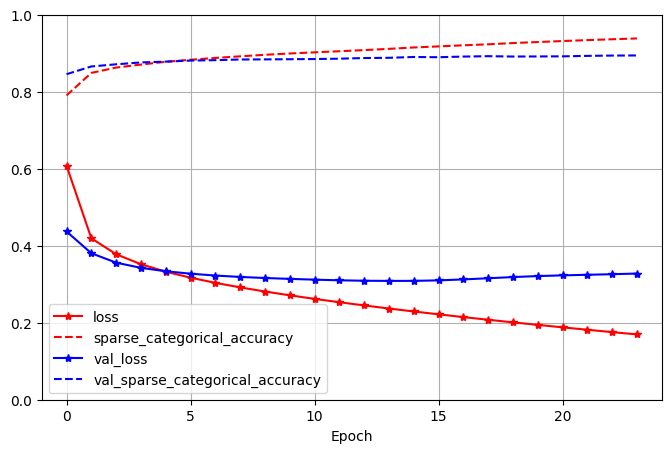

In [45]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[-1, len(h)], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r-*", "r--", "b-*", "b--"])
plt.legend(loc="lower left")
plt.show()

### Evaluate deep sequential model

In [47]:
# # save model
# model.save(
#     filepath="saved_model/fashion_mnist_model.keras",
#     overwrite=True
# )

In [21]:
saved_model = tf.keras.models.load_model("saved_model/fashion_mnist_model.keras")

In [49]:
loss, acc = saved_model.evaluate(X_val, y_val)
loss, acc

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3049 - sparse_categorical_accuracy: 0.8899


(0.3086012303829193, 0.8881000280380249)

In [50]:
# Get the prediction
val_preds = saved_model.predict(X_val)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [51]:
val_preds[0]

array([9.9985552e-01, 2.8374561e-08, 4.9873765e-06, 2.1376502e-07,
       3.4798013e-08, 1.8860523e-11, 1.3936906e-04, 4.6958119e-12,
       3.9739270e-09, 1.6806985e-11], dtype=float32)

In [54]:
np.argmax(val_preds[0], axis=0)

0

In [55]:
val_preds = np.argmax(val_preds, axis=1)
val_preds[:20]

array([0, 5, 2, 7, 2, 2, 6, 7, 1, 8, 7, 4, 0, 1, 4, 0, 9, 1, 3, 7])

In [63]:
cn = np.array(class_names)
cn

array(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
       'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], dtype='<U11')

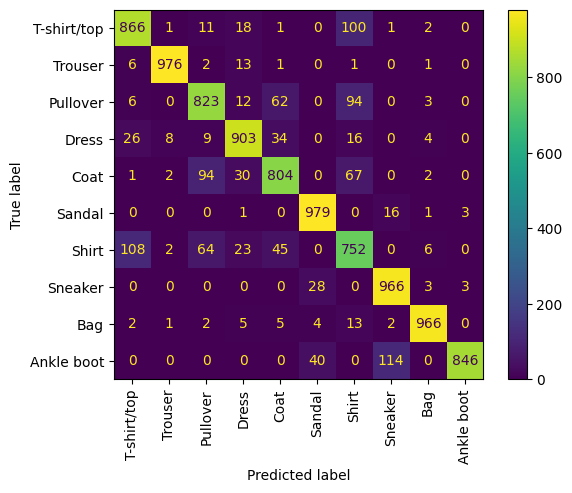

In [66]:
ConfusionMatrixDisplay.from_predictions(
    y_true = y_val,
    y_pred = val_preds,
    display_labels=cn,
    xticks_rotation="vertical"
);

### Error analysis with Gradio

In [67]:
# Get the index of the misclassified values
def misclassified_indices(actual, predicted):
    misclassified_indices = np.flatnonzero(actual != predicted)
    return misclassified_indices

In [68]:
misc = misclassified_indices(y_val, val_preds)
misc[:10]

array([  4,   8,  13,  66,  76,  86,  89,  93, 105, 128])

In [75]:
# Function to use in gradio
def display_error(set):
    if set ==  'val':
        data = X_val
        actual = y_val
        pred = val_preds

    def misclassified_indices(actual, predicted):
        misclassified_indices = np.flatnonzero(actual != predicted)
        return misclassified_indices
    
    misc = misclassified_indices(actual, pred)
    random_index = np.random.choice(misc)

    # Get the data from that index
    image = data[random_index]
    true_value = class_names[actual[random_index]]
    pred_value = class_names[pred[random_index]]

    return true_value, pred_value, image

In [77]:
# display_error('val')

In [70]:
import gradio as gr

In [78]:
# Create the Gradio interface
interface = gr.Interface(
    fn=display_error,
    inputs=[
        gr.Text(),
    ],  
    outputs=[
        gr.Text(label="True Value"),
        gr.Text(label="Predicted Value"),
        gr.Image(value="Image", type="numpy", height=200, width=200)
    ],
    title="Error Analysis",
    description="""
    Step 1: Type in 'val' to display a random misclassified image and its labels.  
    
    Step 2: Click submit over and over again to get random misclassified values
    """
)

# Run the Gradio interface
interface.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Observation. The distinction between shirt, pullover, t-shirt and coat is not very clear.  
This is the same for sandal, sneaker and ankle-boot

Looking at the image, you begin to understand why the model made the mistake which it did

Some of the data are also mislabelled

We might need clearer pictures if we want better accuracy

In [23]:
saved_model.evaluate(X_train, y_train)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2477 - sparse_categorical_accuracy: 0.9083


[0.24456064403057098, 0.9090999960899353]

In [25]:
saved_model.evaluate(X_val, y_val)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3049 - sparse_categorical_accuracy: 0.8899


[0.3086012303829193, 0.8881000280380249]

In [24]:
saved_model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3543 - sparse_categorical_accuracy: 0.8745


[0.35288456082344055, 0.8733000159263611]